# Benchmarking cell2location model using synthetic data

In [1]:
import sys, ast, os
import time
import pickle
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
from plotnine import *
import matplotlib.pyplot as plt 
import matplotlib
data_type = 'float32'
os.environ["THEANO_FLAGS"] = 'device=cuda0,floatX=' + data_type + ',force_device=True'

import cell2location.models as c2l
import cell2location.plt as c2lpl
import cell2location.cluster_averages 
import cell2location

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns
import itertools

# scanpy prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/nfs/users/nfs_v/vk7/.local/lib/python3.7/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
Using cuDNN version 7605 on context None
Mapped name None to device cuda0: Tesla V100-SXM2-32GB (0000:62:00.0)


`THEANO_FLAGS='force_device=True'` forces the package to use GPU. Pay attention to error messages that might indicate theano failed to initalise the GPU.   
Do not forget to change `device=cuda4` to your available GPU id. Use `device=cuda` / `device=cuda0` if you have just one locally or if you are requesting one GPU via HPC cluster job.

## Load input data 

First we load the data.

In [2]:
sp_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/lowdens_synthetic_ST_fewcells/samples_2_v2/'
results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/lowdens_synthetic_ST_fewcells/'

In [3]:
seed_numbers = '10'

In [4]:
# load simulated spatial data desing
design = pd.read_csv(sp_data_folder + 'synthetic_ST_seed'+seed_numbers+'_design.csv',
                    index_col=0)
design.index = ['ref_' + i for i in design.index]
design

,uniform,density,nspots,mean_ncells
ref_Astro_3,0,1.0,160.0,1.047457
ref_Ext_L25,0,1.0,179.0,2.132758
ref_Ext_L6,0,1.0,197.0,1.123235
ref_Oligo_2,0,1.0,180.0,0.059803
ref_Ext_Hpc_1,0,1.0,145.0,1.165331
ref_Inh_Meis2_4,0,1.0,224.0,0.899732
ref_Nb_2,0,0.0,182.0,1.725271
ref_Ext_L23,0,0.0,184.0,2.634801
ref_Inh_Pvalb,1,1.0,1729.0,1.344651
ref_Inh_Vip,0,1.0,218.0,0.243348


```python
# read anndata with synthetic data
adata = anndata.read(sp_data_folder + 'synthetic_ST_seed'+seed_numbers+'_counts_downsampled.h5ad')

import scipy
adata.X = scipy.sparse.csr_matrix(adata.X)
adata.write(sp_data_folder + 'synthetic_ST_seed'+seed_numbers+'_counts_downsampled_sparse.h5ad')
```

```python
# load single cell reference
counts_validation = pickle.load(open(sp_data_folder + 'counts_validation_'+seed_numbers+'.p', 'rb'))
labels_validation = pickle.load(open(sp_data_folder + 'labels_validation_'+seed_numbers+'.p', 'rb'))
adata_snrna_raw = anndata.AnnData(counts_validation, obs=labels_validation)

import scipy
adata_snrna_raw.X = scipy.sparse.csr_matrix(adata_snrna_raw.X)
adata_snrna_raw.write(sp_data_folder + 'snRNA_counts_validation_seed'+seed_numbers+'_sparse.h5ad')
```

In [5]:
# read anndata with synthetic data
adata = anndata.read(sp_data_folder + 'synthetic_ST_seed'+seed_numbers+'_counts_downsampled_sparse.h5ad')
adata.obs.columns = ['ref_' + i for i in adata.obs.columns]
sc.pp.calculate_qc_metrics(adata, inplace=True) 
adata.obs['sample'] = f'seed_{seed_numbers}'

# load single cell reference
adata_snrna_raw = anndata.read(sp_data_folder + 'snRNA_counts_validation_seed'+seed_numbers+'_sparse.h5ad')

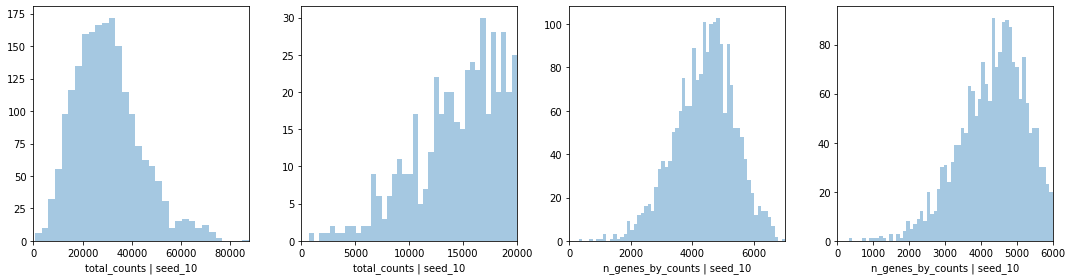

In [6]:
# PLOT QC FOR EACH SAMPLE
fig, axs = plt.subplots(len(adata.obs['sample'].unique()), 
                        4, figsize=(15, 4*len(adata.obs['sample'].unique())))
for i, s in enumerate(adata.obs['sample'].unique()):

    slide = adata
    sns.distplot(slide.obs['total_counts'],
                 kde=False, ax = axs[0])
    axs[0].set_xlim(0, adata.obs['total_counts'].max())
    axs[0].set_xlabel(f'total_counts | {s}')

    sns.distplot(slide.obs['total_counts']\
                 [slide.obs['total_counts']<20000],
                 kde=False, bins=40, ax = axs[1])
    axs[1].set_xlim(0, 20000)
    axs[1].set_xlabel(f'total_counts | {s}')

    sns.distplot(slide.obs['n_genes_by_counts'],
                 kde=False, bins=60, ax = axs[2])
    axs[2].set_xlim(0, adata.obs['n_genes_by_counts'].max())
    axs[2].set_xlabel(f'n_genes_by_counts | {s}')

    sns.distplot(slide.obs['n_genes_by_counts']\
                 [slide.obs['n_genes_by_counts']<6000],
                 kde=False, bins=60, ax = axs[3])
    axs[3].set_xlim(0, 6000)
    axs[3].set_xlabel(f'n_genes_by_counts | {s}')

plt.tight_layout()

Select genes using expression in non-zero cells

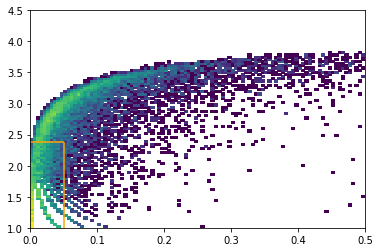

In [7]:
# Select cells
rcParams["axes.facecolor"] = "white"

sc.pp.filter_cells(adata_snrna_raw, min_genes=1)
sc.pp.filter_genes(adata_snrna_raw, min_cells=1)

# calculate the mean of each gene across non-zero cells
adata_snrna_raw.var['n_cells'] = (adata_snrna_raw.X.toarray() > 0).sum(0)
adata_snrna_raw.var['nonz_mean'] = adata_snrna_raw.X.toarray().sum(0) / adata_snrna_raw.var['n_cells']

plt.hist2d(np.log10(adata_snrna_raw.var['nonz_mean']),
           np.log10(adata_snrna_raw.var['n_cells']), bins=100,
           norm=matplotlib.colors.LogNorm(),
           range=[[0,0.5], [1,4.5]]);
nonz_mean_cutoff = 0.05
cell_count_cutoff = np.log10(adata_snrna_raw.shape[0] * 0.001)
cell_count_cutoff2 = np.log10(adata_snrna_raw.shape[0] * 0.03)
plt.vlines(nonz_mean_cutoff, cell_count_cutoff, cell_count_cutoff2, color='orange');
plt.hlines(cell_count_cutoff, nonz_mean_cutoff, 1, color='orange');
plt.hlines(cell_count_cutoff2, 0, nonz_mean_cutoff, color='orange');

In [8]:
adata_snrna_raw[:,(np.array(np.log10(adata_snrna_raw.var['nonz_mean']) > nonz_mean_cutoff)
         | np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff2))
      & np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff)].shape

(8137, 12281)

In [9]:
# select genes based on mean expression in non-zero cells
adata_snrna_raw = adata_snrna_raw[:,(np.array(np.log10(adata_snrna_raw.var['nonz_mean']) > nonz_mean_cutoff)
         | np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff2))
      & np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff)]

In [10]:
adata_snrna_raw

View of AnnData object with n_obs × n_vars = 8137 × 12281
    obs: 'annotation_1', 'n_genes'
    var: 'n_cells', 'nonz_mean'

Add counts matrix as `adata.raw` 

In [11]:
adata_snrna_raw.raw = adata_snrna_raw

In [12]:
adata_vis = adata.copy()
adata_vis.raw = adata_vis

#### Plot numbers of cells and mRNA per spot

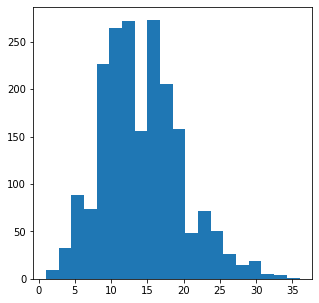

In [13]:
rcParams['figure.figsize'] = 5, 5
cell_count = adata.obs.loc[:, [('ref_' in i) & ('nUMI' not in i)
                               for i in adata.obs.columns]]
plt.hist(cell_count.sum(1), bins=20);

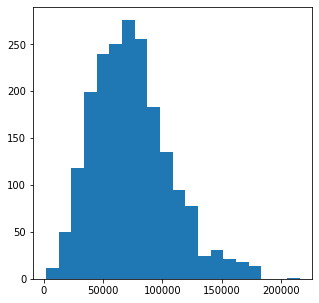

In [14]:
umi_count = adata.obs.loc[:, [('ref_' in i) & ('nUMI' in i)
                               for i in adata.obs.columns]]
plt.hist(umi_count.sum(1), bins=20);

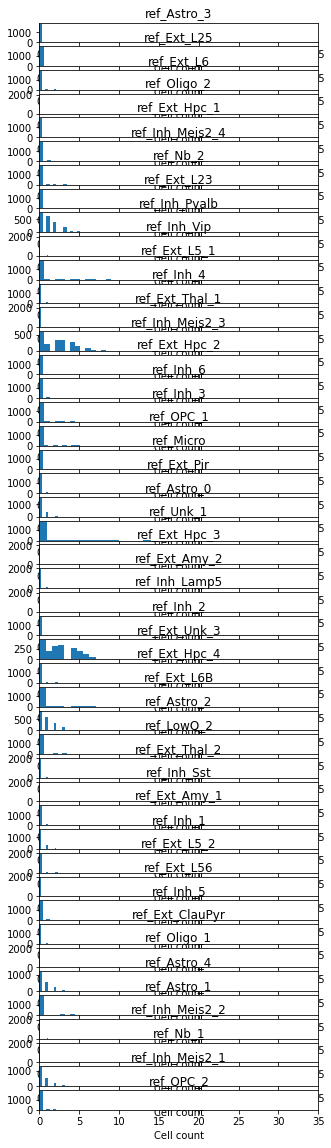

In [15]:
rcParams['figure.figsize'] = 5, 20
for i, c in enumerate(cell_count.columns):
    plt.subplot(cell_count.shape[1], 1, i+1)
    plt.hist(cell_count[c], bins = cell_count.max().max());
    plt.xlabel('Cell count');
    plt.xlim(0, 35);
    plt.title(str(c));
plt.tight_layout()

In [16]:
adata_vis.var['ENSEMBL'] = adata_vis.var_names

In [17]:
from re import sub
adata_snrna_raw.obs['sample'] = [sub('_.+$','', i) for i in adata_snrna_raw.obs.index]

### First, infer average expression in each cell type

### Creating model ### - time 0.01 min
### Analysis name: RegressionGeneBackgroundCoverageTorch_48covariates_8137cells_12281genes
### Training model to determine n_epochs with CV ###


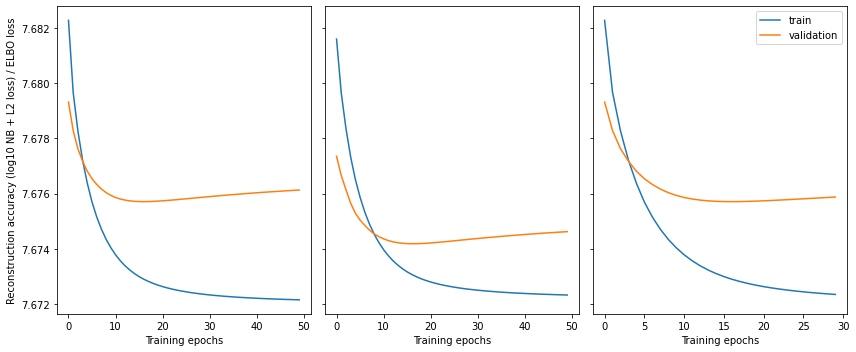

### Re-training model to stop before overfitting ###


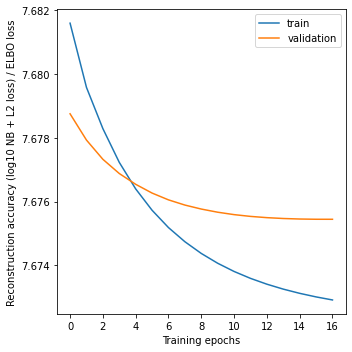

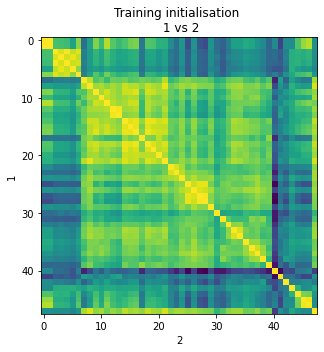

### Evaluating parameters / sampling posterior ### - time 1.94 min


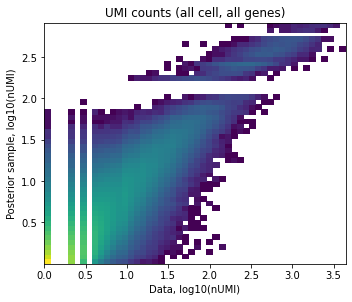

### Saving results ###


... storing 'sample' as categorical


### Plotting results ###


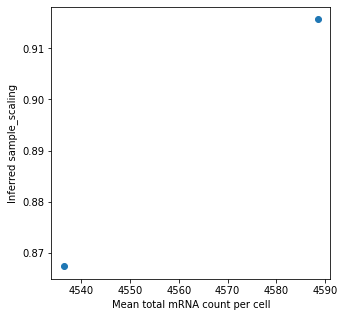

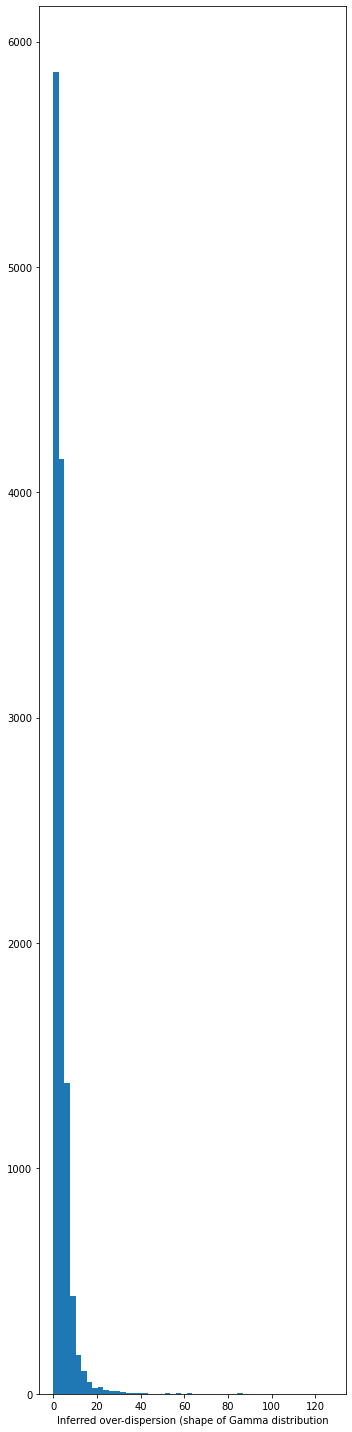

### Done ### - time 2.28 min


In [18]:
from cell2location import run_regression
r, adata_snrna_raw = run_regression(adata_snrna_raw, 
                   
                   verbose=True, return_all=True,
                                 
                   train_args={
                    'covariate_col_names': ['annotation_1'], 
                    'sample_name_col': 'sample',
                    'tech_id': None,
                    'stratify_cv': 'annotation_1',
                       
                    'n_epochs': 50, 'minibatch_size': 1024, 'learning_rate': 0.01,
                       
                    'use_average_as_initial_value': True, 'use_cuda': True,
                       
                    'train_proportion': 0.9,
                    #'l2_weight': {'l2_weight': 0.001, 'sample_scaling_weight': 0.5,
                    #       'gene_overdisp_weight': 0.1},  # True = use defaults for the model
                    
                    'readable_var_name_col': None, 'use_raw': True},
                                 
                   model_kwargs={},
                   posterior_args={},
                                 
                   export_args={'path': results_folder + 'regression_model/', 'save_model': True,
                                'run_name_suffix': ''})

reg_mod = r['mod']

In [20]:
reg_mod_name = 'RegressionGeneBackgroundCoverageTorch_48covariates_8137cells_12281genes'
reg_path = f'{results_folder}regression_model/{reg_mod_name}/'

adata_snrna_raw = sc.read(f'{reg_path}sc.h5ad')
r = pickle.load(file = open(f'{reg_path}model_.p', "rb"))
r

{'mod': <cell2location.models.RegressionGeneBackgroundCoverageTorch.RegressionGeneBackgroundCoverageTorch at 0x14ed40e0f790>,
 'model_name': None,
 'train_args': {'covariate_col_names': ['annotation_1'],
  'sample_name_col': 'sample',
  'tech_name_col': None,
  'stratify_cv': 'annotation_1',
  'n_epochs': 50,
  'minibatch_size': 1024,
  'learning_rate': 0.01,
  'minibatch_seed': [41, 56, 345, 12, 6, 3],
  'use_average_as_initial_value': True,
  'use_cuda': True,
  'train_proportion': 0.9,
  'retrain': True,
  'l2_weight': True,
  'sample_prior': False,
  'readable_var_name_col': None,
  'use_raw': True,
  'mode': 'normal',
  'n_type': 'restart',
  'n_restarts': 2,
  'checkpoints': None,
  'tech_id': None,
  'var_names': Index(['ENSMUSG00000051951', 'ENSMUSG00000089699', 'ENSMUSG00000033845',
         'ENSMUSG00000033813', 'ENSMUSG00000002459', 'ENSMUSG00000033793',
         'ENSMUSG00000025905', 'ENSMUSG00000025907', 'ENSMUSG00000090031',
         'ENSMUSG00000033740',
         ...
   

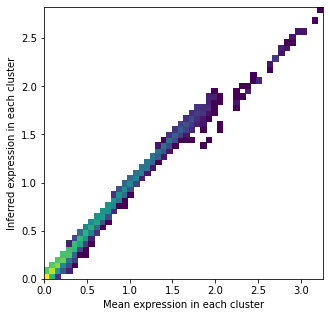

In [21]:
# export inferred averages in each cluster
inf_aver = pd.DataFrame(#adata_snrna_raw.uns['regression_mod']['post_sample_q05']['gene_factors'].T,
                        adata_snrna_raw.uns['regression_mod']['post_sample_means']['gene_factors'].T,
             index=adata_snrna_raw.uns['regression_mod']['var_names'], 
             columns=adata_snrna_raw.uns['regression_mod']['fact_names'])
inf_aver = inf_aver.loc[:, np.array(['annotation_1_' in i for i in inf_aver.columns])]
from re import sub
inf_aver.columns = [sub('annotation_1_', '', i) for i in inf_aver.columns]
inf_aver = inf_aver.iloc[:, inf_aver.columns.argsort()]

# scale up by average sample scaling factor
inf_aver = inf_aver * adata_snrna_raw.uns['regression_mod']['post_sample_means']['sample_scaling'].mean()

# compute mean expression of each gene in each cluster
aver = cell2location.cluster_averages.cluster_averages.get_cluster_averages(adata_snrna_raw, 'annotation_1')
aver = aver.loc[adata_snrna_raw.var_names, inf_aver.columns]

# export inferred averages in each cluster
#inf_aver = reg_mod.covariate_effects.copy()
#from re import sub
#inf_aver.columns = [sub('mean_cov_effect_Subset_', '', i) for i in inf_aver.columns]
#inf_aver = inf_aver.loc[aver.index, aver.columns]

rcParams['figure.figsize'] = 5, 5
plt.hist2d(np.log10(aver.values.flatten()+1), np.log10(inf_aver.values.flatten()+1),
           bins=50, norm=matplotlib.colors.LogNorm());
plt.xlabel('Mean expression in each cluster');
plt.ylabel('Inferred expression in each cluster');

In [22]:
inf_aver

,Astro_0,Astro_1,Astro_2,Astro_3,Astro_4,Ext_Amy_1,Ext_Amy_2,Ext_ClauPyr,Ext_Hpc_1,Ext_Hpc_2,...,Inh_Vip,LowQ_2,Micro,Nb_1,Nb_2,OPC_1,OPC_2,Oligo_1,Oligo_2,Unk_1
ENSMUSG00000051951,0.020953,0.016042,0.084593,0.042583,7.471205e-09,15.380912,13.135906,4.288376,7.784131,13.621282,...,5.342487,3.876348,2.016624e-02,1.484032,0.280992,1.504990,0.546771,1.912494,0.603592,1.180341
ENSMUSG00000089699,0.003343,0.002083,0.007729,0.026444,2.950024e-02,3.160022,2.925348,1.291368,1.715286,2.455252,...,1.075745,1.078793,6.528705e-09,0.576349,0.108668,0.387554,0.081044,0.587330,0.137649,0.207395
ENSMUSG00000033845,0.045551,0.072674,0.032863,0.079684,4.896606e-02,0.270030,0.200164,0.219300,0.153339,0.389210,...,0.063719,0.042517,4.721685e-02,0.085306,0.044439,0.061864,0.046935,0.075602,0.051885,0.021118
ENSMUSG00000033813,0.105475,0.071894,0.081807,0.125628,2.097502e-02,0.165544,0.188240,0.101986,0.175698,0.235967,...,0.123723,0.240626,7.958978e-02,0.129971,0.028316,0.105877,0.085717,0.087375,0.048908,0.014800
ENSMUSG00000002459,2.564245,0.908491,4.182149,1.544953,2.314408e+00,0.631534,0.648626,1.326456,0.119412,0.097489,...,0.243948,0.068271,9.009078e-03,0.073741,0.242293,0.436685,0.099000,0.084829,0.005862,0.090930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000064370,0.219976,0.059693,0.109191,0.005696,7.669561e-09,0.329822,0.304451,0.299714,0.122590,0.149735,...,0.229015,0.169650,2.919877e-02,0.074044,0.029530,0.104779,0.139552,0.020287,0.057827,0.015307
ENSMUSG00000051412,0.031449,0.030914,0.015367,0.028366,7.653092e-09,0.015583,0.087819,0.062307,0.100476,0.125855,...,0.127061,0.014006,8.132781e-03,0.093948,0.063700,0.037792,0.070133,0.092643,0.052161,0.003213
ENSMUSG00000079834,0.109765,0.195513,0.291250,0.291790,3.046316e-02,0.340328,0.427474,0.346246,0.151056,0.462471,...,0.320401,0.129060,5.788251e-02,0.054049,0.025273,0.153157,0.176496,0.189963,0.083800,0.055714
ENSMUSG00000095041,0.194612,0.175601,0.196674,0.207787,4.238489e-02,1.848139,1.857760,2.497276,2.670177,2.895661,...,0.931774,1.766798,1.003854e+00,1.059188,0.231707,0.312289,0.596687,0.239618,0.102460,0.105443


## Model training

`cell2location.run_cell2location` is a wrapper for cell2location model workflow:
We summarise train the model, sample posterior to obtain 5% quantile, mean and sigma estimates, save and export results, including diagnostic plots.

`cell2location.run_cell2location` takes single cell and spatial anndata as input together with a bunch of parameters.

In [23]:
results_folder

'/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/lowdens_synthetic_ST_fewcells/'

In [24]:
rcParams['figure.figsize'] = 5, 5
r = cell2location.run_cell2location(
    
                      sc_data=inf_aver,
                      sp_data=adata_vis,
    
                      verbose=True, return_all=True,
    
                      summ_sc_data_args={'cluster_col': "annotation_1"},
    
                      train_args={'n_iter': 30000, 'learning_rate': 0.005,
                                  'total_grad_norm_constraint': 200,
                                  'sample_prior': False, 'n_prior_samples': 20,
                                  'readable_var_name_col': "ENSEMBL"},
    
                      posterior_args={'n_samples': 1000},
                      export_args={'path': results_folder,
                                   'save_model': False, 
                                   'run_name_suffix': '_defaults_ceps9_cps4_fps5_inf_shape01_gl2_code_ocean',
                                   'scanpy_coords_name': 'X_spatial'},
                      model_kwargs={
                                    'cell_number_prior': {'cells_per_spot': 9, 'factors_per_spot': 5, 
                                                          'combs_per_spot': 4
                                                         },
                                    'gene_level_prior':{'mean': 1/2, 'sd': 1/4}
                      }
)

### Summarising single cell clusters ###
### Creating model ### - time 0.01 min
### Analysis name: LocationModelLinearDependentW_1experiments_46clusters_2000locations_12281genes_defaults_ceps9_cps4_fps5_inf_shape01_gl2_code_ocean
### Training model ###


Finished [100%]: Average Loss = 2.3767e+07


Finished [100%]: Average Loss = 2.3767e+07



### Sampling posterior ### - time 20.69 min



### Saving results ###


... storing 'sample' as categorical


### Ploting results ###
### Plotting posterior of W / cell locations ###
### Done ### - time 22.06 min


### Evaluate inferred cell (`spot_factors`) and mRNA (`nUMI_factors`) abundance

In [25]:
r_load = {'run_name': 'LocationModelLinearDependentW_1experiments_46clusters_2000locations_12281genes_defaults_ceps9_cps4_fps5_inf_shape01_gl2_code_ocean'}

fig_path=results_folder +r_load['run_name']+'/plots'

sp_data_file = results_folder +r_load['run_name']+'/sp.h5ad'
adata_vis_res = anndata.read(sp_data_file)

In [26]:
file = results_folder + r_load['run_name']+'/model_.p'
r = pickle.load(file = open(file, "rb"))

In [29]:
from re import sub
cell_count_columns = [sub('ref_', '', i) for i in cell_count.columns]

spot_factors = adata_vis_res.obs[['mean_spot_factors' + i for i in cell_count_columns]]
spot_factors.columns =  ['ref_' + sub('mean_spot_factors', '', i) for i in spot_factors.columns]

spot_factors_sd = adata_vis_res.obs[['sd_spot_factors' + i for i in cell_count_columns]]
spot_factors_sd.columns =  ['ref_' + sub('sd_spot_factors', '', i) for i in spot_factors_sd.columns]

infer_cell_count = spot_factors[cell_count.columns]

nUMI_factors = adata_vis_res.obs[['mean_nUMI_factors' + i for i in cell_count_columns]]
nUMI_factors.columns =  [sub('mean_nUMI_factors', 'ref_', i) for i in nUMI_factors.columns]

infer_cell_count = spot_factors[cell_count.columns]
infer_nUMI_count = nUMI_factors[cell_count.columns]

# mean number of cell types per location
(cell_count.values > 0).sum(1).mean(), (cell_count.values).sum(1).mean(),\
 (infer_cell_count.values > 1).sum(1).mean(), (infer_cell_count.values).sum(1).mean() # estimated

(6.252, 14.08, 1.865, 7.51801455087815)

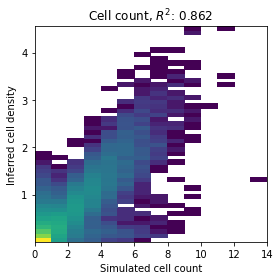

In [30]:
rcParams['figure.figsize'] = 4, 4
rcParams["axes.facecolor"] = "white"

plt.hist2d(cell_count.values.flatten(), 
           infer_cell_count.values.flatten(),
           bins=[cell_count.values.max(), 50], norm=matplotlib.colors.LogNorm());
plt.xlabel('Simulated cell count');
plt.ylabel('Inferred cell density');
plt.title(r'Cell count, $R^2$: ' \
          + str(np.round(np.corrcoef(cell_count.values.flatten(), 
           infer_cell_count.values.flatten()), 3)[0,1]));
plt.tight_layout()
plt.savefig(fig_path + '/Cell_density_cor.pdf')

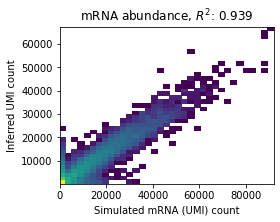

In [31]:
rcParams['figure.figsize'] = 4, 4.5
rcParams["axes.facecolor"] = "white"

plt.hist2d(umi_count.values.flatten(), 
           nUMI_factors.values.flatten() \
           / np.mean(adata_vis_res.var['gene_level'].values),
           bins=[35, 41], norm=matplotlib.colors.LogNorm());
plt.xlabel('Simulated mRNA (UMI) count');
plt.ylabel('Inferred UMI count');
plt.title('mRNA abundance, $R^2$: ' \
          + str(np.round(np.corrcoef(umi_count.values.flatten(), 
           nUMI_factors.values.flatten()), 3)[0,1]));
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.savefig(fig_path + '/nUMI_abundance_cor.pdf')

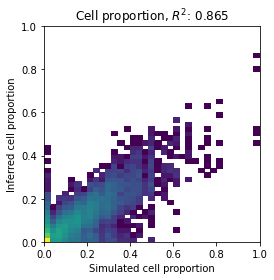

In [32]:
cell_proportions = (cell_count.T / cell_count.sum(1)).T
cell_proportions.iloc[np.isnan(cell_proportions.values)] = 0
infer_cell_proportions = (infer_cell_count.T / infer_cell_count.sum(1)).T

rcParams['figure.figsize'] = 4, 4
plt.hist2d(cell_proportions.values.flatten(), 
           infer_cell_proportions.values.flatten(),
           bins=[35, 41], norm=matplotlib.colors.LogNorm());
plt.xlabel('Simulated cell proportion');
plt.ylabel('Inferred cell proportion');
plt.title('Cell proportion, $R^2$: ' \
          + str(np.round(np.corrcoef(cell_proportions.values.flatten(), 
           infer_cell_proportions.values.flatten()), 3)[0,1]));
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(0, 1);
plt.ylim(0, 1);
plt.tight_layout()
plt.savefig(fig_path + '/Cell_proportion_cor.pdf')

### Split results by sparsity and abundance of cell types

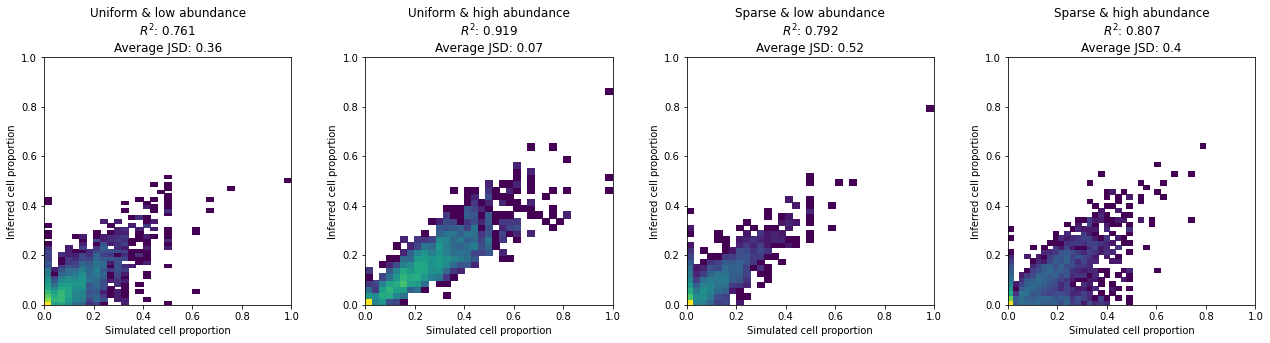

In [34]:
def KL(a, b):
    a = np.asarray(a, dtype=np.float)
    b = np.asarray(b, dtype=np.float)

    return np.sum(np.where(a != 0, a * np.log2(a / b), 0))
from scipy.spatial.distance import jensenshannon

def hist_obs_sim(cell_count, infer_cell_count,
                 xlab='Simulated cell proportion',
                 ylab='Inferred cell proportion',
                 title='', compute_kl=True, equal=True):
    
    cor = np.round(np.corrcoef(cell_count.values.flatten(), 
               infer_cell_count.values.flatten()), 3)[0,1]
    max_val = np.concatenate([cell_count.values.flatten(), 
                               infer_cell_count.values.flatten()]).max()
    title = title +'\n'+ r'$R^2$: ' + str(cor)
    
    if compute_kl:
        
        js = np.array([jensenshannon(cell_count.values[r,:], infer_cell_count.values[r,:]) 
                 for r in range(cell_count.shape[0])])
        js = np.mean(js[~np.isnan(js)])
        title = title + '\nAverage JSD: ' + str(np.round(js, 2))
    
    if np.max(cell_count.values) > 1:
        x_bins = np.max(cell_count.values)
        max_val = None
    else:
        x_bins = 35
        max_val = 1
    
    plt.hist2d(cell_count.values.flatten(), 
               infer_cell_count.values.flatten(),
               bins=[x_bins, 35], norm=matplotlib.colors.LogNorm());
    plt.xlabel(xlab);
    plt.ylabel(ylab);
    if equal:
        plt.gca().set_aspect('equal', adjustable='box')
    plt.xlim(0, max_val);
    plt.ylim(0, max_val);
    plt.title(title);
    
def hist_by_category(cell_count, infer_cell_count, design,
                 xlab='Simulated cell proportion',
                 ylab='Inferred cell proportion',
                 nrow=1, ncol=4, compute_kl=True, equal=True):

    design_loc = design.loc[cell_count.columns,:]
    
    plt.subplot(nrow, ncol, 1)
    ind = (design_loc['uniform'] * design_loc['density']).values.astype(bool)
    hist_obs_sim(cell_count.loc[:,ind], infer_cell_count.loc[:,ind],
                 xlab=xlab,
                 ylab=ylab,
                 title='Uniform & low abundance',
                 compute_kl=compute_kl, equal=equal)
    
    plt.subplot(nrow, ncol, 2)
    ind = (design_loc['uniform'] * (1 - design_loc['density'])).values.astype(bool)
    hist_obs_sim(cell_count.loc[:,ind], infer_cell_count.loc[:,ind],
                 xlab=xlab,
                 ylab=ylab,
                 title='Uniform & high abundance',
                 compute_kl=compute_kl, equal=equal)
    
    plt.subplot(nrow, ncol, 3)
    ind = ((1 - design_loc['uniform']) * design_loc['density']).values.astype(bool)
    hist_obs_sim(cell_count.loc[:,ind], infer_cell_count.loc[:,ind],
                 xlab=xlab,
                 ylab=ylab,
                 title='Sparse & low abundance',
                 compute_kl=compute_kl, equal=equal)
    
    plt.subplot(nrow, ncol, 4)
    ind = ((1 - design_loc['uniform']) * (1 - design_loc['density'])).values.astype(bool)
    hist_obs_sim(cell_count.loc[:,ind], infer_cell_count.loc[:,ind],
                 xlab=xlab,
                 ylab=ylab,
                 title='Sparse & high abundance',
                 compute_kl=compute_kl, equal=equal)
    
cell_proportions = (cell_count.T / cell_count.sum(1)).T
cell_proportions.iloc[np.isnan(cell_proportions.values)] = 0
infer_cell_proportions = (infer_cell_count.T / infer_cell_count.sum(1)).T

rcParams['figure.figsize'] = 18,4.5 #9,9 #20, 4.5
rcParams["axes.facecolor"] = "white"
hist_by_category(cell_proportions, infer_cell_proportions, design,
                 xlab='Simulated cell proportion',
                 ylab='Inferred cell proportion',
                 #compute_kl=False, 
                 nrow=1, ncol=4, equal=True)
plt.tight_layout()

plt.savefig(fig_path + '/hist_by_category.pdf')

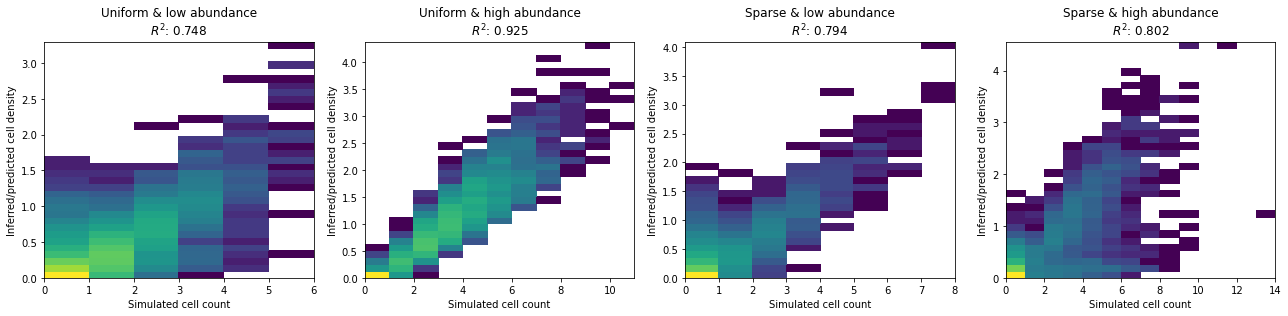

In [35]:
rcParams['figure.figsize'] = 18, 4.5
rcParams["axes.facecolor"] = "white"
hist_by_category(cell_count, infer_cell_count, design,
                 xlab='Simulated cell count',
                 ylab='Inferred/predicted cell density',
                 compute_kl=False, equal=False)
plt.tight_layout()
plt.savefig(fig_path + '/hist_density_by_category.pdf')

### Evaluate estimated gene expression level difference between technologies (`gene_level`)

In [36]:
gene_level = pd.DataFrame(adata_vis_res.uns['mod']['post_sample_means']['gene_level'].flatten(),
                 index=adata_vis_res.uns['mod']['var_names'],
                 columns=['inferred_gene_level'])
adata_vis_res.var['inferred_gene_level'] = gene_level.reindex(index=adata_vis_res.var_names)['inferred_gene_level']

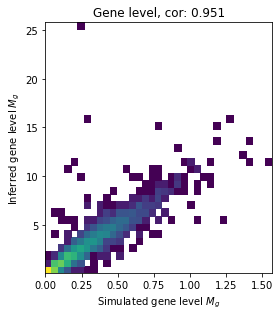

In [37]:
rcParams['figure.figsize'] = 4, 4.5
var = adata_vis_res.var
var = var.loc[~var['inferred_gene_level'].isna(),:]
plt.hist2d(var['gene_level'].values.flatten() / 5, 
           var['inferred_gene_level'].values.flatten(),
           bins=35, norm=matplotlib.colors.LogNorm());
plt.xlabel(r'Simulated gene level $M_g$');
plt.ylabel('Inferred gene level $M_g$');
plt.title('Gene level, cor: ' \
          + str(np.round(np.corrcoef(var['gene_level'].values.flatten(), 
                var['inferred_gene_level'].values.flatten()), 3)[0,1]));
plt.tight_layout();
plt.savefig(fig_path + '/hist_gene_level.pdf')

## Compare per-spot accuracy of cell2location using Precision-Recall

In [38]:
def compute_precision_recall(pos_cell_count, infer_cell_proportions):
    r""" Plot precision-recall curves on average and for each cell type.
    :param pos_cell_count: binary matrix showing which cell types are present in which locations
    :param infer_cell_proportions: inferred locations (the higher the more cells)
    """
    
    from sklearn.metrics import precision_recall_curve
    from sklearn.metrics import average_precision_score
    
    ### calculating ###
    predictor = infer_cell_proportions.values
    # For each cell type
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i, c in enumerate(infer_cell_proportions.columns):
        precision[c], recall[c], _ = precision_recall_curve(pos_cell_count[:, i],
                                                            predictor[:, i])
        average_precision[c] = average_precision_score(pos_cell_count[:, i], predictor[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(pos_cell_count.ravel(),
                                                                    predictor.ravel())
    average_precision["micro"] = average_precision_score(pos_cell_count, predictor,
                                                         average="micro")
    
    return precision, recall, average_precision

def plot_precision_recall(pos_cell_count, infer_cell_proportions,
                          title='', iso_f1_curves=False,
                          individual_cell_types=True,
                          save=None):
    r""" Plot precision-recall curves on average and for each cell type.
    :param pos_cell_count: binary matrix showing which cell types are present in which locations
    :param infer_cell_proportions: inferred locations (the higher the more cells)
    :param title: plot title
    :param iso_f1_curves: plot iso curves for F1 score?
    :param individual_cell_types: show precision-recall curves for each cell type?
    """
    
    ### calculating ###
    precision, recall, average_precision = compute_precision_recall(pos_cell_count, 
                                                                    infer_cell_proportions)
    ### plotting ###
    from itertools import cycle
    # setup plot details
    colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

    lines = []
    labels = []
    
    if iso_f1_curves:
        f_scores = np.linspace(0.2, 0.8, num=4)
        
        for f_score in f_scores:
            x = np.linspace(0.01, 1)
            y = f_score * x / (2 * x - f_score)
            l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
            plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

        lines.append(l)
        labels.append('iso-f1 curves')
    
    l, = plt.plot(recall["micro"], precision["micro"], color='navy', lw=2)
    lines.append(l)
    labels.append('micro-average Precision-recall (area = {0:0.2f})'
                  ''.format(average_precision["micro"]))

    if individual_cell_types:
        for i, color in zip(infer_cell_proportions.columns, colors):
            l, = plt.plot(recall[i], precision[i], color='gold', lw=1)
            lines.append(l)
        labels.append('Precision-recall for individual cell types')



    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(lines, labels, loc=(0, -.18), prop=dict(size=14))
    
    if save is not None:
        plt.savefig(save)

In [39]:
import matplotlib as mpl
from matplotlib import pyplot as plt

with plt.style.context('seaborn'):
    seaborn_colors = mpl.rcParams['axes.prop_cycle'].by_key()['color']
seaborn_colors
sc.pl.palettes.default_102

def compare_precision_recall(pos_cell_count, infer_cell_proportions,
                             method_title, title='',
                             legend_loc=(0, -.18),
                             colors=sc.pl.palettes.default_102):
    
    r""" Plot precision-recall curves on average and for each cell type.
    :param pos_cell_count: binary matrix showing which cell types are present in which locations
    :param infer_cell_proportions: inferred locations (the higher the more cells), 
                                        list of inferred parameters for several methods
    :param method_title: title for each infer_cell_proportions
    :param title: plot title
    """
    # setup plot details
    from itertools import cycle
    colors = cycle(colors)
    lines = []
    labels = []
    roc = {}
    
    ### plotting ###
    for i, color in zip(range(len(infer_cell_proportions)), colors):
        
        precision, recall, average_precision = compute_precision_recall(pos_cell_count, 
                                                                    infer_cell_proportions[i])
        l, = plt.plot(recall["micro"], precision["micro"], color=color, lw=3)
        lines.append(l)
        
        labels.append(method_title[i] + ' (area = {0:0.2f})'
                  ''.format(average_precision["micro"]))
        roc[method_title[i]] = average_precision["micro"]


    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    if legend_loc is not None:
        plt.legend(lines, labels, loc=legend_loc, prop=dict(size=14))

    #plt.show()
    return roc
    
def read_cell_maps(results_folder, run_name, cell_count, post_type='mean'):
    
    # read anndata object, extract data
    sp_data_file = results_folder + run_name + '/sp.h5ad'
    adata_vis_res = anndata.read(sp_data_file)
    
    # read pickle with extra info
    file = results_folder + run_name+'/model_.p'
    r = pickle.load(file = open(file, "rb"))
    
    # extract data
    from re import sub
    cell_count_columns = [sub('ref_', '', i) for i in cell_count.columns]

    spot_factors = adata_vis_res.obs[[post_type + '_spot_factors' + i for i in cell_count_columns]]
    spot_factors.columns =  ['ref_' + sub(post_type + '_spot_factors', '', i) for i in spot_factors.columns]

    nUMI_factors = adata_vis_res.obs[[post_type + '_nUMI_factors' + i for i in cell_count_columns]]
    nUMI_factors.columns =  [sub(post_type + '_nUMI_factors', 'ref_', i) for i in nUMI_factors.columns]

    infer_cell_count = spot_factors[cell_count.columns]
    infer_nUMI_count = nUMI_factors[cell_count.columns]
    
    infer_cell_proportions = (infer_cell_count.T / infer_cell_count.sum(1)).T
    
    return r['model_name'], infer_cell_proportions, infer_cell_count, infer_nUMI_count

In [52]:
names = []
results = []
names_count = []
results_count = []
results_q05 = []
results_count_q05 = []

run_names = [
    'LocationModelLinearDependentW_1experiments_46clusters_2000locations_12281genes_defaults_ceps9_cps4_fps5_inf_shape01_gl2_code_ocean'
]

for n in run_names:
    name, infer_cell_prop, infer_cell_count, infer_nUMI_count = \
    read_cell_maps(results_folder, n, cell_count, post_type='mean')
    names.append(name)
    results.append(infer_cell_prop)
    names_count.append(name)
    results_count.append(infer_cell_count)
    
    name, infer_cell_prop, infer_cell_count, infer_nUMI_count = \
    read_cell_maps(results_folder, n, cell_count, post_type='q05')
    results_q05.append(infer_cell_prop)
    results_count_q05.append(infer_cell_count)

# add RCTD_df
#results.append(RCTD_df[cell_count.columns])
#results_count.append(RCTD_df[cell_count.columns])
#results_q05.append(RCTD_df[cell_count.columns])
#results_count_q05.append(RCTD_df[cell_count.columns])
#names.append('RCTD')

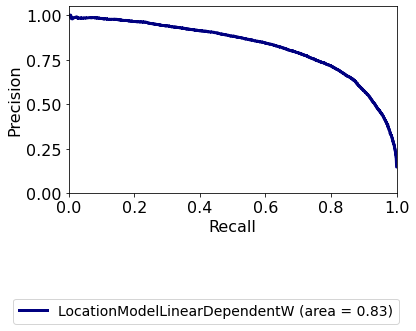

In [55]:
rcParams['figure.figsize'] = 6,5.5 
rcParams['font.size'] = 16
pos_cell_count = cell_count.values > 0
compare_precision_recall(pos_cell_count, [results[i] for i in [0]],
                         method_title=[names[i] for i in [0]],
                         legend_loc=(-0.17, -0.7),
                         colors=['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
plt.tight_layout()
plt.savefig(fig_path + '/ROC_comparison.pdf')

#### Compare using RMSE on proportions

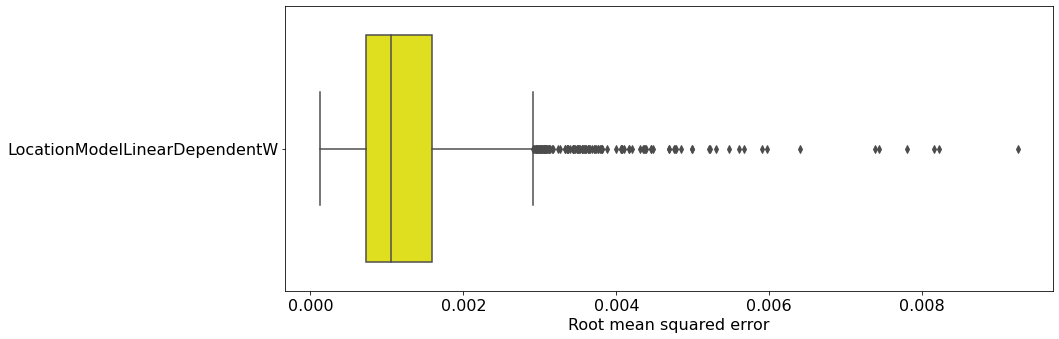

In [56]:
from sklearn.metrics import mean_squared_error
rmse = pd.DataFrame()
for i in range(len(results)):
    rmse[names[i]] = ((cell_proportions - results[i]) ** 2).mean(1)

rcParams['figure.figsize'] = 15, 5
sns.boxplot(data=rmse, orient="h", palette=sc.pl.palettes.default_102).set(
    xlabel='Root mean squared error'
)
plt.tight_layout()
plt.savefig(fig_path + '/RMSE_comparison.pdf')
plt.show()